<a href="https://colab.research.google.com/github/amp77921/RL_Project/blob/main/DQN_Connect6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import numpy as np
import pandas as pd
from IPython.display import display

# Connect 6 class description
class connect_x:

    def __init__(self):
        self.board_height = 6
        self.board_width = 9  # Adjusted board width for Connect-6
        self.win_condition = 6  # Changed to 6 for Connect-6
        self.board_state = np.zeros([self.board_height, self.board_width], dtype=np.int8)
        self.players = {'p1': 1, 'p2': 2}
        self.isDone = False
        self.reward = {'win': 1, 'draw': 0.5, 'lose': -1}

    def render(self):
        rendered_board_state = self.board_state.copy().astype(str)
        rendered_board_state[self.board_state == 0] = ' '
        rendered_board_state[self.board_state == 1] = 'O'
        rendered_board_state[self.board_state == 2] = 'X'
        display(pd.DataFrame(rendered_board_state))

    def reset(self):
        self.__init__()

    def get_available_actions(self):
        available_cols = []
        for j in range(self.board_width):
            if np.sum([self.board_state[:, j] == 0]) != 0:
                available_cols.append(j)
        return available_cols

    # Changed check game for 6
    def check_game_done(self, player):
        if player == 'p1':
            check = '1 1 1 1 1 1'
        else:
            check = '2 2 2 2 2 2'

        # check vertically then horizontally
        for j in range(self.board_width):
            if check in np.array_str(self.board_state[:, j]):
                self.isDone = True
        for i in range(self.board_height):
            if check in np.array_str(self.board_state[i, :]):
                self.isDone = True

        # check left diagonal and right diagonal
        for k in range(0, self.board_height - self.win_condition + 1):
            left_diagonal = np.array([self.board_state[k + d, d] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d + k, self.board_width - d - 1] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                self.isDone = True
        for k in range(1, self.board_width - self.win_condition + 1):
            left_diagonal = np.array([self.board_state[d, d + k] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d, self.board_width - 1 - k - d] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                self.isDone = True

        if self.isDone:
            return self.reward['win']
        # check for draw
        elif np.sum([self.board_state == 0]) == 0:
            self.isDone = True
            return self.reward['draw']
        else:
            return 0.

    def make_move(self, a, player):
        # check if move is valid
        if a in self.get_available_actions():
            i = np.sum([self.board_state[:, a] == 0]) - 1
            self.board_state[i, a] = self.players[player]
        else:
            self.render()

        reward = self.check_game_done(player)

        # give feedback as new state and reward
        return self.board_state.copy(), reward

env = connect_x()

In [133]:
import random

# memory block for deep q learning
class replayMemory:
    def __init__(self):
        self.memory = []

    def dump(self, transition_tuple):
        self.memory.append(transition_tuple)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = replayMemory()

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Defining the DQN Network
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # Calculate the correct size after flattening
        linear_input_size = 6 * 9 * 32  # Adjust width in the size calculation
        self.fc1 = nn.Linear(linear_input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, outputs)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output of the last conv layer
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [135]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


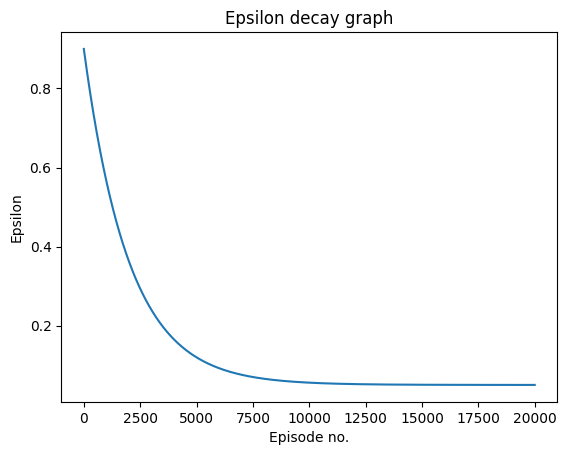

In [136]:
import matplotlib.pyplot as plt
# epilson decay graph
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000

steps_done = np.arange(20000)
eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * steps_done / EPS_DECAY)
plt.plot(steps_done, eps)
plt.title('Epsilon decay graph')
plt.xlabel('Episode no.')
plt.ylabel('Epsilon')
plt.show()

In [137]:
import torch.optim as optim
import random
import math
import torch
import numpy as np

BATCH_SIZE = 256
GAMMA = 0.999

# get max no. of actions from action space
n_actions = env.board_width

height = env.board_height
width = env.board_width

policy_net = DQN(n_actions).to(device)
# target_net will be updated every n episodes to tell policy_net a better estimate of how far off from convergence
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# set target_net in testing mode
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())

# Selects the best action for the model based on the previous q values
def select_action(state, available_actions, steps_done=None, training=True):
    if not available_actions:  # Handle case with no available actions
        return None, None  # This could potentially be handled differently

    # Convert state to a tensor and add batch and channel dimensions
    state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
    epsilon = random.random()

    # Epsilon-greedy threshold
    if training:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    else:
        eps_threshold = 0.0

    if epsilon > eps_threshold:
        with torch.no_grad():
            # Get Q-values from the policy network
            q_values = policy_net(state).flatten()
            # Filter Q-values for available actions only
            q_values_filtered = q_values[available_actions]
            if q_values_filtered.numel() > 0:  # Check if any values are left after filtering
                max_index = torch.argmax(q_values_filtered).item()
                selected_action = available_actions[max_index]
                selected_q_value = q_values_filtered[max_index].item()
            else:
                return None, None
    else:
        selected_action = random.choice(available_actions)
        with torch.no_grad():
            q_values = policy_net(state).flatten()
            selected_q_value = q_values[selected_action].item()

    return selected_action, selected_q_value

In [171]:
import torch.nn.functional as F

# Optimizes the model
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*transitions)

    # Reshape and convert to tensor
    state_batch = torch.tensor(np.array(state_batch), dtype=torch.float, device=device).view(BATCH_SIZE, 1, env.board_height, env.board_width)
    action_batch = torch.tensor(action_batch, dtype=torch.long, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, next_state_batch)), device=device, dtype=torch.bool)
    non_final_next_states = [s for s in next_state_batch if s is not None]

    # Reshape non-final states correctly for network input
    if len(non_final_next_states) > 0:
        non_final_next_states = torch.tensor(np.array(non_final_next_states), dtype=torch.float, device=device).view(-1, 1, env.board_height, env.board_width)

    # Get current Q values from policy net for the actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

    # Compute next state values, initializing them to zero and updating only for non-final states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    if len(non_final_next_states) > 0:
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Calculate the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss between current and expected Q values
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [139]:
# Random agent
def random_agent(actions):
    return random.choice(actions)

# Finds the win rate for the algorithm
def win_rate_test():
    win_moves_taken_list = []
    win = []
    for i in range(100):
        env.reset()
        win_moves_taken = 0

        while not env.isDone:
            state = env.board_state.copy()
            available_actions = env.get_available_actions()
            action, q_value = select_action(state, available_actions, steps_done, training=False)
            state, reward = env.make_move(action, 'p1')
            win_moves_taken += 1

            if reward == 1:
                win_moves_taken_list.append(win_moves_taken)
                win.append(1)
                break

            available_actions = env.get_available_actions()
            action = random_agent(available_actions)
            state, reward = env.make_move(action, 'p2')

    win_rate = sum(win) / 100 if win else 0  # Use the 'if win else 0' to avoid division by zero
    average_moves = sum(win_moves_taken_list) / len(win_moves_taken_list) if win_moves_taken_list else float('inf')
    return win_rate, average_moves

In [174]:
from itertools import count
import pickle
from google.colab import files
import os

# avoid resetting
steps_done = 0
training_history = []
max_q_values_per_episode = []  # List to store the maximum Q value of each episode

num_episodes = 1000
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 10


for i in range(num_episodes):
    env.reset()
    state_p1 = env.board_state.copy()
    max_q_value = float('-inf')  # Initialize the maximum Q value for this episode to negative infinity

    for t in count():
        available_actions = env.get_available_actions()
        if not available_actions:  # No more valid moves
            break  # End the game or handle as a terminal state

        action_p1, q_value = select_action(state_p1, available_actions, steps_done, training=True)
        if action_p1 is None:
            continue  # Skip this step if no valid action was selected

        if q_value > max_q_value:  # Update max Q value if the current Q value is higher
            max_q_value = q_value

        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')
        memory.dump([state_p1, action_p1, reward_p1, state_p1_ if not env.isDone else None])

        if env.isDone:
            break

        # Random move for Player 2
        available_actions = env.get_available_actions()  # Refresh available actions after p1's move
        if available_actions:  # Check if there are still available moves
            action_p2 = random_agent(available_actions)
            state_p2_, reward_p2 = env.make_move(action_p2, 'p2')
            memory.dump([state_p1_, action_p2, reward_p2, state_p2_ if not env.isDone else None])
            if env.isDone:
                break

        # Perform one step of the optimization (on the policy network)
        #optimize_model()

    max_q_values_per_episode.append(max_q_value if max_q_value != float('-inf') else 0)  # Store the maximum Q value of the episode

    if i % TARGET_UPDATE == TARGET_UPDATE - 1:
        target_net.load_state_dict(policy_net.state_dict())  # Update the target network

    if i % 20 == 0 and i > 0:
        win_rate, moves_taken = win_rate_test()
        training_history.append([i + 1, win_rate, moves_taken])
        if i % 200 == 0:
            print(f'Episode {i}: | win_rate: {win_rate} | moves_taken: {moves_taken}')

# File path
file_path = 'q_values_connect6_ra.pkl'

# Check if the file already exists
if os.path.exists(file_path):
    os.remove(file_path)  # Remove the file if it exists

# Save the new maximum Q values to the file
with open(file_path, 'wb') as f:
    pickle.dump(max_q_values_per_episode, f)

# Download the file
files.download(file_path)

print('Complete')

Episode 200: | win_rate: 0.77 | moves_taken: 9.272727272727273
Episode 400: | win_rate: 0.74 | moves_taken: 7.837837837837838
Episode 600: | win_rate: 0.76 | moves_taken: 7.7105263157894735
Episode 800: | win_rate: 0.81 | moves_taken: 8.506172839506172


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Complete


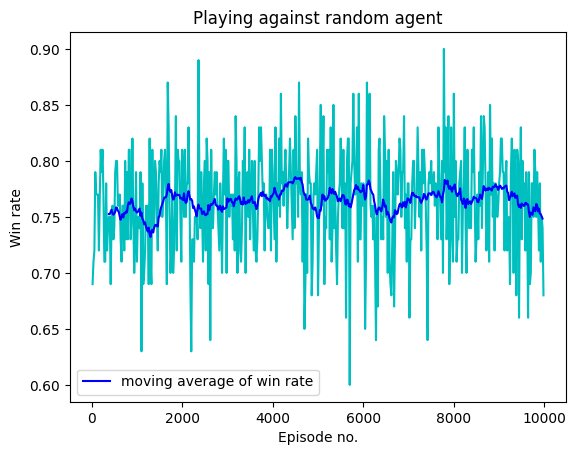

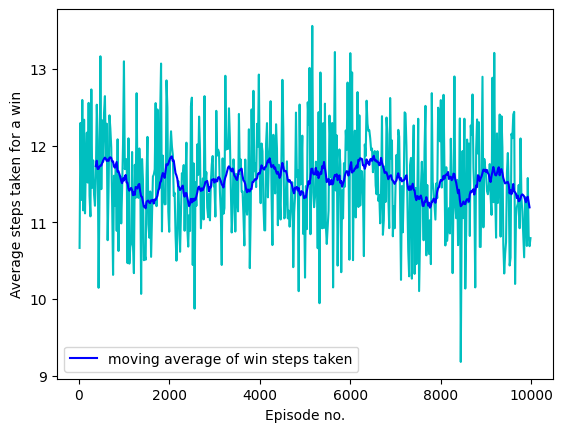

In [175]:
plt.plot(th[:, 0], th[:, 1], c='c')
win_rate_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 1])] for i in range(len(th) - 19)])

plt.plot(win_rate_moving_average[:, 0], win_rate_moving_average[:, 1], c='b', label='moving average of win rate')
plt.legend()
plt.title('Playing against random agent')
plt.xlabel('Episode no.')
plt.ylabel('Win rate')
plt.show()

plt.plot(th[:, 0], th[:, 2], c='c')
win_steps_taken_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 2])] for i in range(len(th) - 19)])

plt.plot(win_steps_taken_moving_average[:, 0], win_steps_taken_moving_average[:, 1], c='b', label='moving average of win steps taken')
plt.legend()
plt.xlabel('Episode no.')
plt.ylabel('Average steps taken for a win')
plt.show()

In [177]:
from IPython.display import clear_output
import time

def demo():
    env.reset()
    env.render()

    while not env.isDone:
        state = env.board_state.copy()
        available_actions = env.get_available_actions()
        if not available_actions:
            print("No available actions.")
            break

        action, _ = select_action(state, available_actions, steps_done, training=False)
        if action is not None:
            state, reward = env.make_move(action, 'p1')
            clear_output(wait=True)
            env.render()
            time.sleep(1)  # Pause for visibility

            if reward == env.reward['win']:
                print("Player 1 wins!")
                break

        available_actions = env.get_available_actions()
        if available_actions:
            action = random_agent(available_actions)
            state, reward = env.make_move(action, 'p2')
            clear_output(wait=True)
            env.render()
            time.sleep(1)  # Pause for visibility

            if reward == env.reward['win']:
                print("Player 2 wins!")
                break
        else:
            print("No available actions for Player 2.")
            break

demo()

,0,1,2,3,4,5,6,7,8
0,,,,,,,O,,
1,,,,,,,O,,
2,,,,,,,O,,
3,,,,,,,O,,
4,,,,,,X,O,,
5,,,X,,,X,O,X,X


Player 1 wins!
